In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import datasets as ds
import math
import utils as ut

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

import pickle

### 1. Carga de información

In [2]:
critics_df = ds.get_dataset("../data/raw/rotten_tomatoes_critic_reviews.csv")

critics_df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


* `rotten_tomatoes_link`: Sirve como identificador de la película
* `critic_name`: Nombre del critico que comento la película
* `top_critic`: Valor booleano que aclara si el crítico es un crítico destacado o no
* `publisher_name`: nombre de la editorial para la que trabaja el crítico
* `review_type`: Determina si la reseña es positiva (fresh) o negativa (rotten)
* `review_score`: Puntaje proporcionado por el crítico
* `review_date`: Fecha de la reseña
* `review_content`: Contenido de la reseña

### 2. Exploración y limpieza

**2.1. Comprensión de datos**

In [3]:
print(f'El dataframe contiene {critics_df.shape[0]} filas y {critics_df.shape[1]} columnas.')

El dataframe contiene 1130017 filas y 8 columnas.


**2.2. Identificando nulos y duplicados**

In [4]:
critics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130017 entries, 0 to 1130016
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   rotten_tomatoes_link  1130017 non-null  object
 1   critic_name           1111488 non-null  object
 2   top_critic            1130017 non-null  bool  
 3   publisher_name        1130017 non-null  object
 4   review_type           1130017 non-null  object
 5   review_score          824081 non-null   object
 6   review_date           1130017 non-null  object
 7   review_content        1064211 non-null  object
dtypes: bool(1), object(7)
memory usage: 61.4+ MB


In [5]:
print(critics_df.isnull().sum())

print("Duplicados:", critics_df.duplicated().sum())

rotten_tomatoes_link         0
critic_name              18529
top_critic                   0
publisher_name               0
review_type                  0
review_score            305936
review_date                  0
review_content           65806
dtype: int64
Duplicados: 119471


In [6]:
critics_df = critics_df.drop_duplicates()
critics_df = critics_df.dropna(subset=['review_content'])

* los nulis en el nombre del critico se contrastan con el de publisher name asi que no es grave y se piede mantener
* el de review score se compensa con  el de review type ya que determina si es util o no
* El de texto si es necesario arreglarlo para cuando se haga el NLP

**2.3. Eliminando información irrelevante**

In [7]:
cr_cleaned = critics_df.copy().drop(columns=['review_date', 'review_score', 'critic_name'])

cr_cleaned.head()

,rotten_tomatoes_link,top_critic,publisher_name,review_type,review_content
0,m/0814255,False,Urban Cinefile,Fresh,A fantasy adventure that fuses Greek mythology...
1,m/0814255,False,Urban Cinefile,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,False,FILMINK (Australia),Fresh,With a top-notch cast and dazzling special eff...
3,m/0814255,False,Sunday Mail (Australia),Fresh,Whether audiences will get behind The Lightnin...
4,m/0814255,True,Hollywood Reporter,Rotten,What's really lacking in The Lightning Thief i...


* La fecha no es relevante para el estudio
* El puntaje tiene sus nulos, además de que ya hay un boolean que dice si la reseña sera positiva o negativa
* El nombre del critico no hace falta si ya esta el de la editorial que lo publica

### 3. Análisis univariante
**3.1. Dividir el Dataset en categoricos y numericos**

In [8]:
c_df_copy = cr_cleaned.copy()
c_df_copy.dtypes.unique()

array([dtype('O'), dtype('bool')], dtype=object)

* Todas son categoricas

**3.2. Análisis sober variables categóricas**

In [9]:
print(c_df_copy['rotten_tomatoes_link'].value_counts().head(10))
print(f"Total de productos únicos: {c_df_copy['rotten_tomatoes_link'].nunique()}")
print("------------------------------------------------------")
print(c_df_copy['publisher_name'].value_counts().head(10))
print(f"Total de editoriales únicos: {c_df_copy['publisher_name'].nunique()}")

rotten_tomatoes_link
m/joker_2019                         574
m/once_upon_a_time_in_hollywood      554
m/us_2019                            535
m/avengers_endgame                   528
m/captain_marvel                     523
m/a_star_is_born_2018                517
m/black_panther_2018                 512
m/star_wars_the_rise_of_skywalker    496
m/solo_a_star_wars_story             474
m/star_wars_the_last_jedi            473
Name: count, dtype: int64
Total de productos únicos: 17697
------------------------------------------------------
publisher_name
New York Times        11816
Variety               10404
Time Out               9035
Los Angeles Times      9017
Slant Magazine         8073
Washington Post        8058
Hollywood Reporter     8045
eFilmCritic.com        7984
Village Voice          7345
Chicago Sun-Times      7202
Name: count, dtype: int64
Total de editoriales únicos: 2229


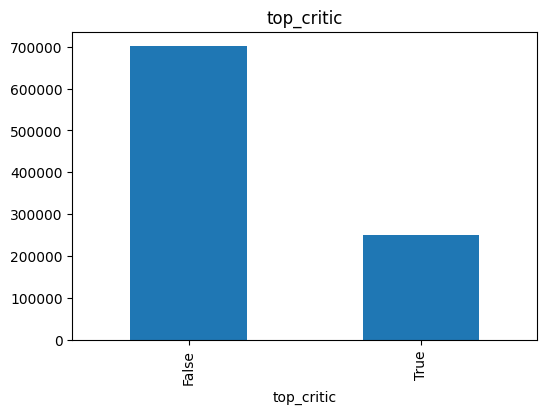

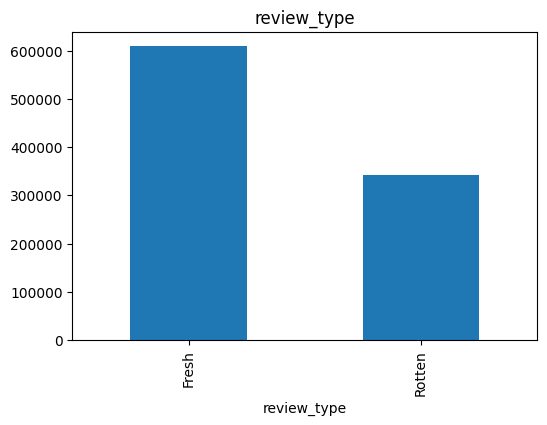

In [10]:
categorical_cols = [ 'top_critic', 'review_type']


for col in categorical_cols:
    c_df_copy[col].value_counts().plot(kind='bar', figsize=(6,4), title=col)
    plt.show()


* La mayoría de críticos no son destacados en una proporción casi dos veces mas que los que si lo son
* Las reseñas positivas son casi el doble a las de negativas

Top 10 peliculas graficados: 10
Top 10 editoriales graficados: 10


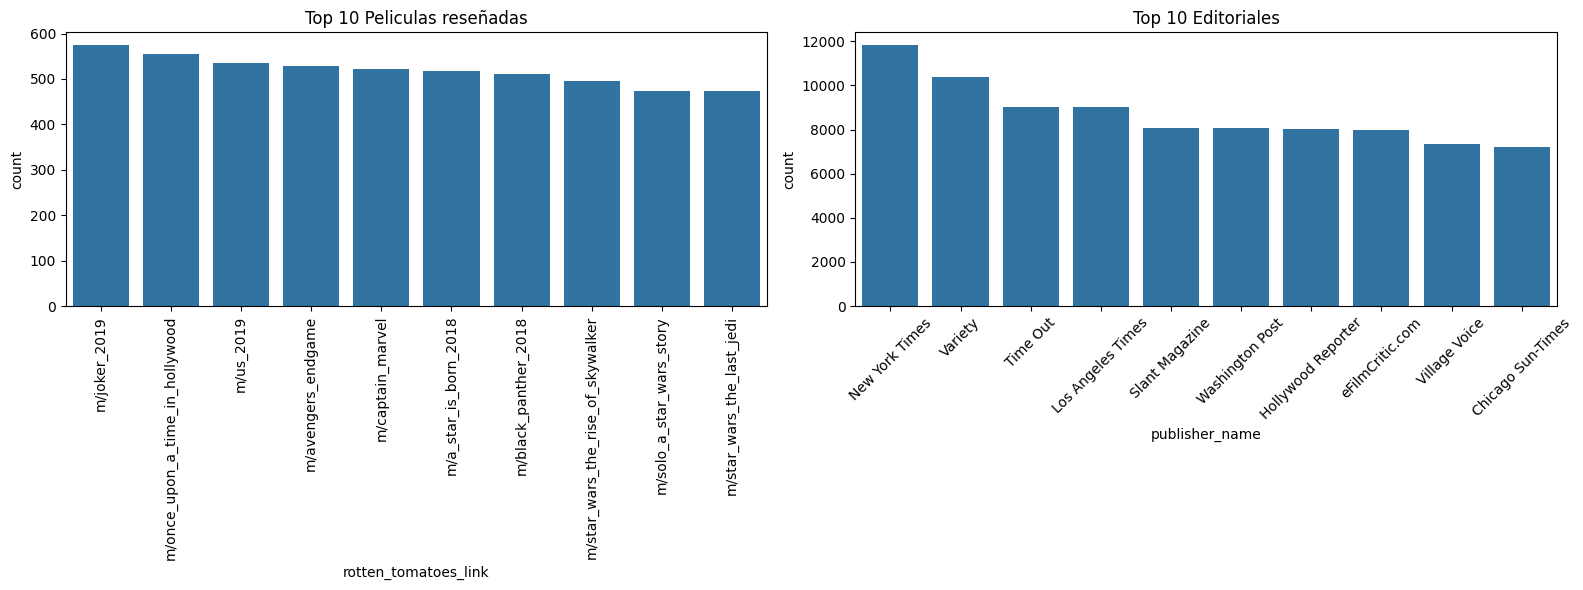

In [11]:
top_n_peliculas = 10
top_n_editorial = 10

fig, axis = plt.subplots(1, 2, figsize=(16, 6))

# PRODUCTOS
top_products = c_df_copy['rotten_tomatoes_link'].value_counts().head(top_n_peliculas).index
sns.countplot(ax=axis[0], data=c_df_copy, x='rotten_tomatoes_link', order=top_products)
axis[0].set_title("Top 10 Peliculas reseñadas")
axis[0].tick_params(axis='x', rotation=90)
print("Top 10 peliculas graficados:", len(top_products))

# USUARIOS
top_users = c_df_copy['publisher_name'].value_counts().head(top_n_editorial).index
sns.countplot(ax=axis[1], data=c_df_copy, x='publisher_name', order=top_users)
axis[1].set_title("Top 10 Editoriales")
axis[1].tick_params(axis='x', rotation=45)
print("Top 10 editoriales graficados:", len(top_users))

plt.tight_layout()
plt.show()

* El top de peliculas reseñadas esta rodeando las 500 reseñas
* La editorial con mas reseñas de películas es New York Times con casi 12000, avanzando de manera descendente hasta Chicado Sun-Times con casi 8000

### 4. Análisis multivariante
**4.3. Categorico-Categorico Análisis**

In [12]:
def cat_cat(df, cat1, cat2, top_n_cat1=None, top_n_cat2=None):
    
    if top_n_cat1:
        top_values1 = df[cat1].value_counts().nlargest(top_n_cat1).index
        df = df[df[cat1].isin(top_values1)]
    if top_n_cat2:
        top_values2 = df[cat2].value_counts().nlargest(top_n_cat2).index
        df = df[df[cat2].isin(top_values2)]
    
    ct = pd.crosstab(df[cat1], df[cat2])
    
    ct_prop = ct.div(ct.sum(axis=1).replace(0,1), axis=0)
    
    ct_prop.plot(kind='bar', stacked=True, figsize=(12,6))
    plt.xlabel(cat1)
    plt.ylabel('Proporción')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=cat2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


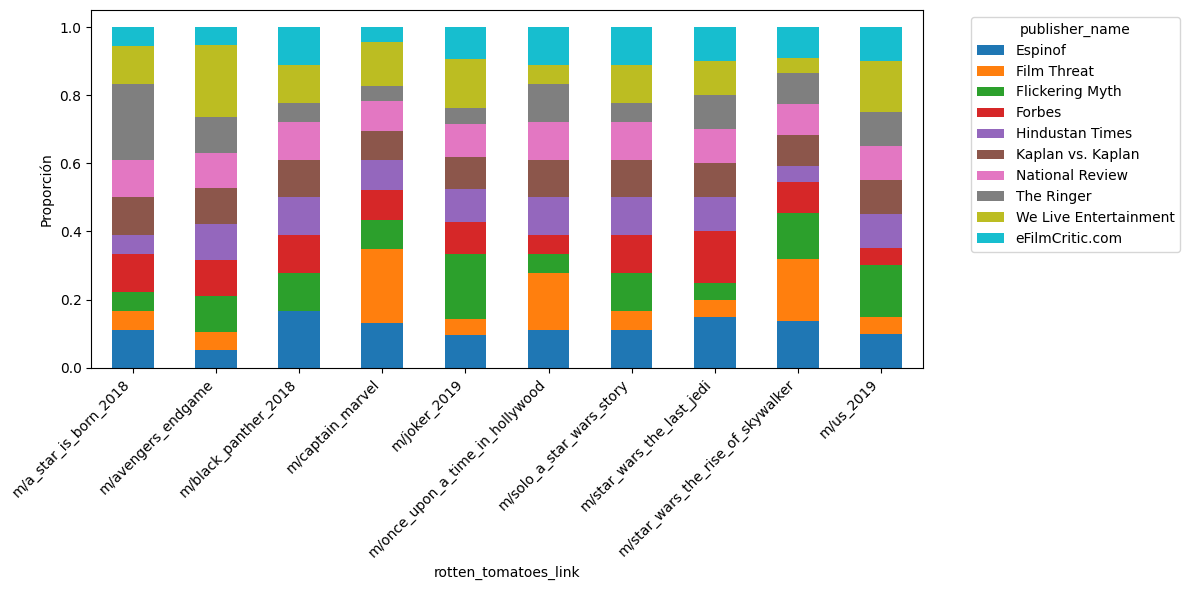

In [13]:
cat_cat(c_df_copy, 'rotten_tomatoes_link', 'publisher_name', top_n_cat1=top_n_peliculas, top_n_cat2=top_n_editorial)

* Parece que eFilmCritic.com es quien mas reseñas hace a las peliculas con mas reseñas del top

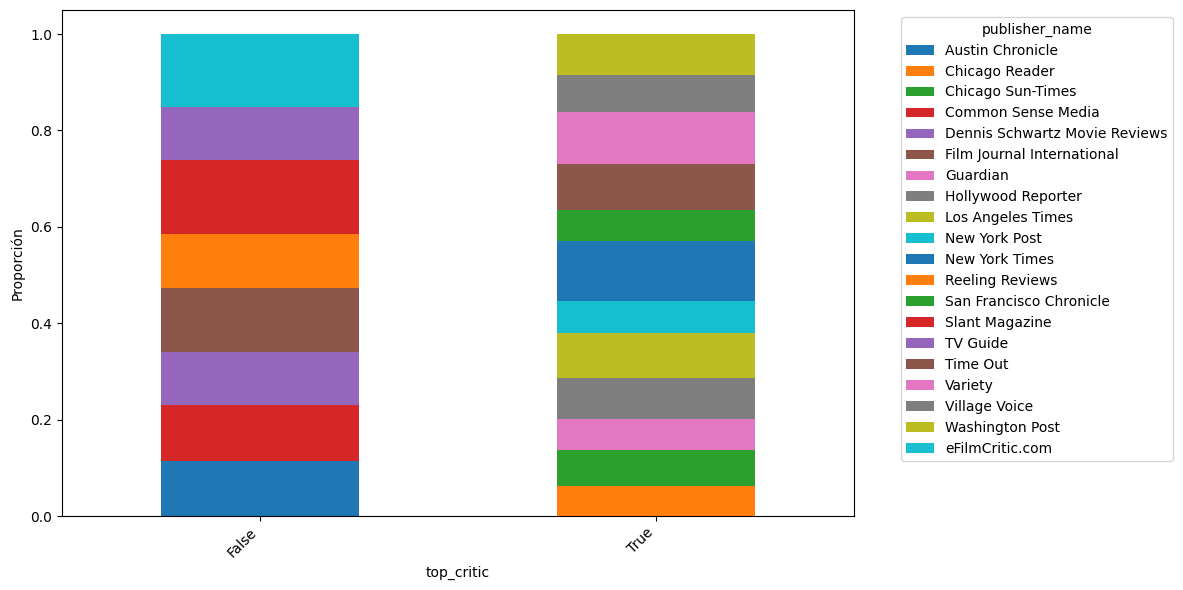

In [14]:
cat_cat(c_df_copy, 'top_critic', 'publisher_name', top_n_cat2=20)

* Se ve que la mayoría de las editoriales con mas reseñas tienen criticos cuya opinion es validada, es imporatnte teniendo en cuenta que hay mas con la categoría false que con la de true

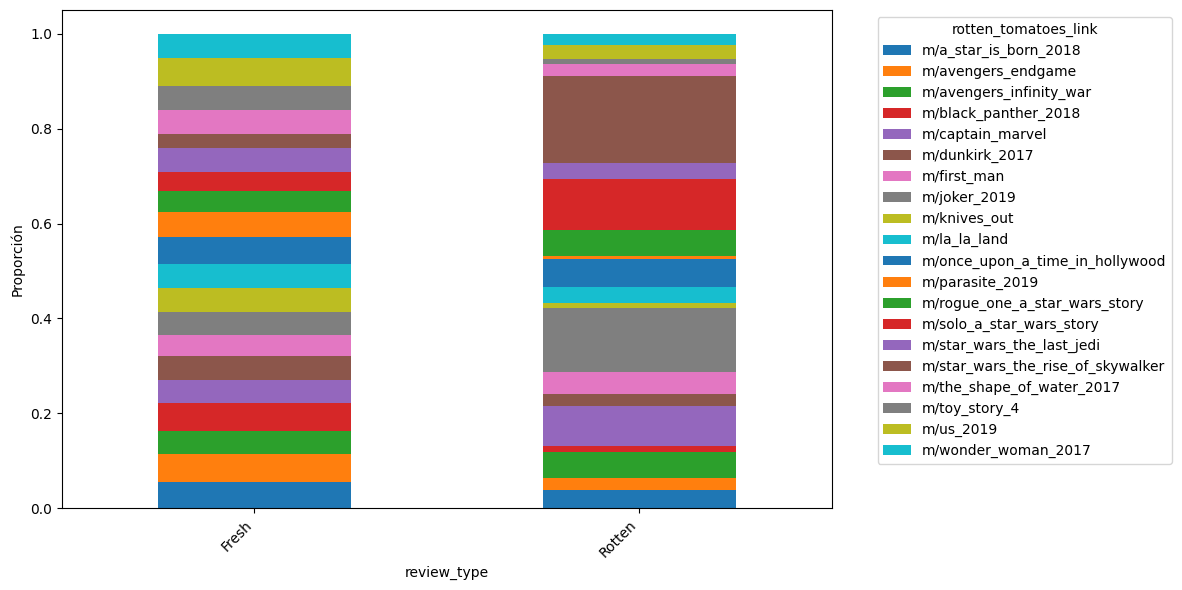

In [15]:
cat_cat(c_df_copy, 'review_type', 'rotten_tomatoes_link', top_n_cat2=20)

* Las buenas reseñas estan distribuidas mas equitativamente entre las peliculas mientras que las malas se acumulan, esto demestra que se le da importancia a que hay pelis con mas reseñas malas que buenas

### 5. Ingeniería de características

**5.1. Preparar los datos**

* Como primera etapa vamos a mapear las reseñas de frescas o podridas como boolean

In [16]:
c_df_copy['review_label'] = c_df_copy['review_type'].map({'Fresh': 1, 'Rotten': 0})

print(c_df_copy[['review_type', 'review_label']].head())
c_df_copy.drop(columns=['review_type'], inplace=True)


  review_type  review_label
0       Fresh             1
1       Fresh             1
2       Fresh             1
3       Fresh             1
4      Rotten             0


In [17]:
c_df_copy.head()

,rotten_tomatoes_link,top_critic,publisher_name,review_content,review_label
0,m/0814255,False,Urban Cinefile,A fantasy adventure that fuses Greek mythology...,1
1,m/0814255,False,Urban Cinefile,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,m/0814255,False,FILMINK (Australia),With a top-notch cast and dazzling special eff...,1
3,m/0814255,False,Sunday Mail (Australia),Whether audiences will get behind The Lightnin...,1
4,m/0814255,True,Hollywood Reporter,What's really lacking in The Lightning Thief i...,0


In [21]:
c_df_copy['top_critic_num'] = c_df_copy['top_critic'].astype(int)
c_df_copy.drop(columns=['top_critic'], inplace=True)

In [22]:
c_df_copy['review_len'] = c_df_copy['review_content'].str.len()

# cantidad de palabras
c_df_copy['review_word_count'] = c_df_copy['review_content'].str.split().apply(len)

In [23]:
c_df_copy.head()

,rotten_tomatoes_link,publisher_name,review_content,review_label,review_len,review_word_count,top_critic_num
0,m/0814255,Urban Cinefile,A fantasy adventure that fuses Greek mythology...,1,176,29,0
1,m/0814255,Urban Cinefile,"Uma Thurman as Medusa, the gorgon with a coiff...",1,153,25,0
2,m/0814255,FILMINK (Australia),With a top-notch cast and dazzling special eff...,1,121,20,0
3,m/0814255,Sunday Mail (Australia),Whether audiences will get behind The Lightnin...,1,213,37,0
4,m/0814255,Hollywood Reporter,What's really lacking in The Lightning Thief i...,0,147,26,1


**5.2. Análisis de outliers**

* Para la longitud de reseñas se tendra en cuenta que tenga un minimo de longitud para que eralmente cuente

In [31]:
c_df_copy = c_df_copy[(c_df_copy['review_len'] >= 10) & (c_df_copy['review_len'] <= 5000)]


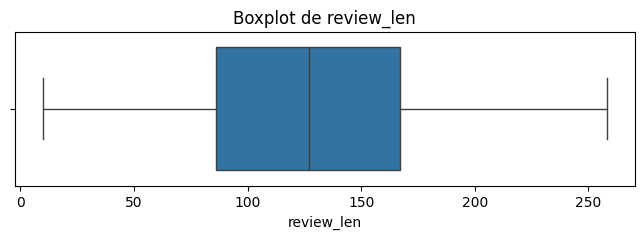

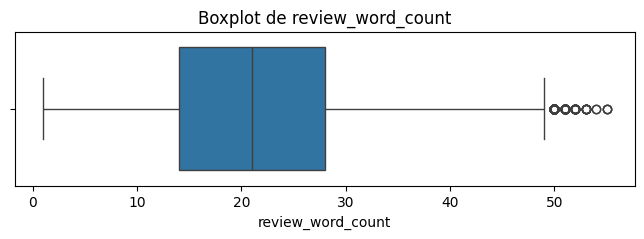

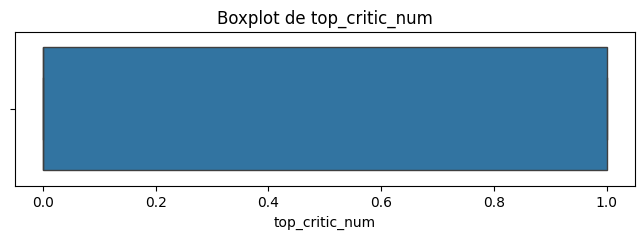

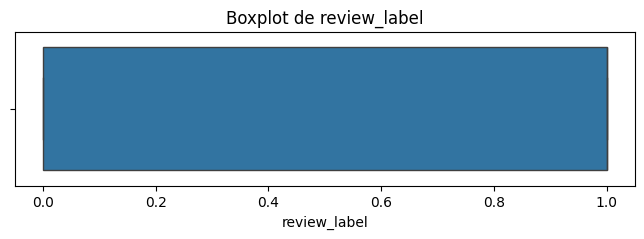

In [32]:
num_cols = ['review_len', 'review_word_count', 'top_critic_num', 'review_label']

for col in num_cols:
    plt.figure(figsize=(8,2))
    sns.boxplot(x=c_df_copy[col])
    plt.title(f'Boxplot de {col}')
    plt.show()



**5.2. Dividir el train/test de marcos de datos**

In [34]:
X = c_df_copy['review_content']  
y = c_df_copy['review_label']    

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 6. Transformar el texto en matriz

In [35]:
vec_model = CountVectorizer(stop_words = "english", max_features=5000)
X_train_vec = vec_model.fit_transform(X_train)
X_test_vec = vec_model.transform(X_test)

### 7. Contruir el naive bayes

In [37]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

y_pred_nb = nb_model.predict(X_test_vec)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.771371048287898


### 8. Optimización

In [38]:
def evaluar_modelo(model, X_train_vec, X_test_vec, y_train, y_test, nombre="Modelo"):
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    print(f"{nombre} Accuracy: {acc:.5f}")
    return model, y_pred

In [39]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

hyperparams = {
    'vectorizer__max_features': [1000, 2000, 3000, None],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0.1, 2.0, 20)
}

In [40]:
# Naive Bayes simple
vec_model = CountVectorizer(stop_words="english")
X_train_vec = vec_model.fit_transform(X_train)
X_test_vec  = vec_model.transform(X_test)

nb_model = MultinomialNB()
nb_model, y_pred_nb = evaluar_modelo(nb_model, X_train_vec, X_test_vec, y_train, y_test, "Naive Bayes")

Naive Bayes Accuracy: 0.79712


In [41]:
# 5. Naive Bayes optimizado con Pipeline + RandomizedSearchCV
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

hyperparams = {
    'vectorizer__max_features': [1000, 2000, 3000, None],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0.1, 2.0, 20)
}

grid = RandomizedSearchCV(pipeline, hyperparams, scoring="accuracy", n_iter=20, random_state=42)
grid.fit(X_train, y_train)

best_nb_model = grid.best_estimator_
y_pred_best_nb = best_nb_model.predict(X_test)

print("Naive Bayes Optimizado Accuracy:", accuracy_score(y_test, y_pred_best_nb))
print("Mejores parámetros:", grid.best_params_)

Naive Bayes Optimizado Accuracy: 0.8029742317356519
Mejores parámetros: {'vectorizer__ngram_range': (1, 2), 'vectorizer__max_features': None, 'nb__alpha': np.float64(0.7)}


In [42]:
#Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model, y_pred_log = evaluar_modelo(log_model, X_train_vec, X_test_vec, y_train, y_test, "Logistic Regression")

Logistic Regression Accuracy: 0.80569


In [43]:
acc_nb = accuracy_score(y_test, y_pred_best_nb)
acc_log = accuracy_score(y_test, y_pred_log)

if acc_log > acc_nb:
    modelo_final = log_model
    nombre_final = "Logistic Regression"
else:
    modelo_final = best_nb_model
    nombre_final = "Naive Bayes Optimizado"

print(f"Mejor modelo: {nombre_final} ({max(acc_nb, acc_log):.5f})")

Mejor modelo: Logistic Regression (0.80569)


### 9. Guardar Modelo

In [49]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer(stop_words="english")),
    ("classifier", modelo_final)   
])

pipeline.fit(X_train, y_train)

# Guardar el pipeline completo
with open("../models/rotten_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("Pipeline con modelo final guardado correctamente.")


Pipeline con modelo final guardado correctamente.


In [ ]:
ruta_pipeline = "../models/rotten_pipeline.pkl"
with open(ruta_pipeline, "rb") as f:
    pipeline_cargado = pickle.load(f)

pruebas = [
    "The movie was amazing, I loved every minute of it!",
    "Absolutely terrible. I wasted two hours of my life.",
    "It was okay, some parts were good but others were boring.",
    "A masterpiece of cinematography and storytelling.",
    "Horrible acting and a very weak plot.",
]


predicciones = pipeline_cargado.predict(pruebas)

for review, pred in zip(pruebas, predicciones):
    etiqueta = "Positive" if pred == 1 else "Negative"
    print(f"Review: {review}\nPredicted sentiment: {etiqueta}\n")



Review: The movie was amazing, I loved every minute of it!
Predicted sentiment: Positive

Review: Absolutely terrible. I wasted two hours of my life.
Predicted sentiment: Negative

Review: It was okay, some parts were good but others were boring.
Predicted sentiment: Negative

Review: A masterpiece of cinematography and storytelling.
Predicted sentiment: Positive

Review: Horrible acting and a very weak plot.
Predicted sentiment: Negative

